In [25]:
import pandas as pd
import glob

In [26]:
path = 'datasets' 

todos_los_archivos = glob.glob(path + "/*.csv")

print(todos_los_archivos)

['datasets\\Defunciones 2018.csv', 'datasets\\Defunciones 2019.csv', 'datasets\\Defunciones 2020.csv', 'datasets\\Defunciones 2021.csv', 'datasets\\Defunciones 2022.csv', 'datasets\\Defunciones 2023.csv', 'datasets\\Defunciones 2024.csv']


In [27]:
lista_de_dataframes = []
print("Iniciando la lectura de archivos con codificación flexible...")

for archivo in todos_los_archivos:
    try:
        df_temporal = pd.read_csv(archivo, encoding='utf-8-sig')
        print(f"✔️  Éxito con 'utf-8-sig': {archivo.split('/')[-1]}")
    except UnicodeDecodeError:
        try:
            df_temporal = pd.read_csv(archivo, encoding='latin1')
            print(f"Éxito con 'latin1': {archivo.split('/')[-1]}")
        except Exception as e:
            print(f"No se pudo leer el archivo '{archivo.split('/')[-1]}'. Error: {e}")
            continue

    lista_de_dataframes.append(df_temporal)

if lista_de_dataframes:
    df_final = pd.concat(lista_de_dataframes, axis=0, ignore_index=True)
    print("\n¡Archivos combinados exitosamente!")
else:
    print("\nNo se pudo leer ningún archivo.")
    df_final = pd.DataFrame() 

Iniciando la lectura de archivos con codificación flexible...
✔️  Éxito con 'utf-8-sig': datasets\Defunciones 2018.csv
✔️  Éxito con 'utf-8-sig': datasets\Defunciones 2019.csv
✔️  Éxito con 'utf-8-sig': datasets\Defunciones 2020.csv
✔️  Éxito con 'utf-8-sig': datasets\Defunciones 2021.csv
✔️  Éxito con 'utf-8-sig': datasets\Defunciones 2022.csv
Éxito con 'latin1': datasets\Defunciones 2023.csv
Éxito con 'latin1': datasets\Defunciones 2024.csv

¡Archivos combinados exitosamente!


C:\Users\geo_s\AppData\Local\Temp\ipykernel_15040\915684080.py:10: DtypeWarning: Columns (1,2,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_temporal = pd.read_csv(archivo, encoding='latin1')


In [28]:
if not df_final.empty:
    print("\nColumnas antes de la limpieza:")
    print(df_final.columns)

    columnas_a_renombrar = {
        'ï»¿municipio': 'municipio',
        'aÃÂ±o_defuncion': 'año_defuncion'
    }
    
    df_final.rename(columns=columnas_a_renombrar, inplace=True)

    # df_final['municipio'] = df_final['municipio'].fillna(df_final['municipio_viejo'])
    # df_final.drop(columns=['municipio_viejo'], inplace=True)
    
    print("\nColumnas después de la limpieza:")
    print(df_final.columns)
    
    print("\n--- Vista Previa del DataFrame Final Limpio ---")
    print(df_final.head())


Columnas antes de la limpieza:
Index(['municipio', 'fecha_registro', 'hora_defuncion', 'sexo', 'edad',
       'año_defuncion', 'mes_defuncion', 'dia_defuncion'],
      dtype='object')

Columnas después de la limpieza:
Index(['municipio', 'fecha_registro', 'hora_defuncion', 'sexo', 'edad',
       'año_defuncion', 'mes_defuncion', 'dia_defuncion'],
      dtype='object')

--- Vista Previa del DataFrame Final Limpio ---
   municipio fecha_registro hora_defuncion sexo  edad  año_defuncion  \
0       43.0     28/11/2018       21:15:00    M  46.0         2018.0   
1       18.0     23/01/2020       12:30:00    M  97.0         2018.0   
2       36.0     28/11/2018       00:00:00    M  74.0         2018.0   
3       35.0     13/03/2020       06:00:00    M  86.0         2018.0   
4       42.0     11/03/2020            NaN    M  79.0         2018.0   

   mes_defuncion  dia_defuncion  
0           11.0           27.0  
1           10.0           22.0  
2           11.0           28.0  
3         

In [29]:
df_final = df_final.drop('fecha_registro', axis=1)
df_final = df_final.drop('hora_defuncion', axis=1)
df_final = df_final.drop('dia_defuncion', axis=1)

In [30]:
df_final.head(10)

,municipio,sexo,edad,año_defuncion,mes_defuncion
0,43.0,M,46.0,2018.0,11.0
1,18.0,M,97.0,2018.0,10.0
2,36.0,M,74.0,2018.0,11.0
3,35.0,M,86.0,2018.0,8.0
4,42.0,M,79.0,2018.0,12.0
5,43.0,M,65.0,2018.0,4.0
6,66.0,F,88.0,2018.0,5.0
7,36.0,M,66.0,2018.0,11.0
8,42.0,M,65.0,2018.0,3.0
9,18.0,F,47.0,2018.0,12.0


In [ ]:
df_agrupado = df_final.groupby(['municipio', 'año_defuncion']).size().reset_index(name='total')

df_agrupado.head(10)

,municipio,año_defuncion,total
0,1.0,2018.0,12
1,1.0,2019.0,14
2,1.0,2020.0,22
3,1.0,2021.0,20
4,1.0,2022.0,7
5,1.0,2023.0,12
6,1.0,2024.0,13
7,2.0,2018.0,423
8,2.0,2019.0,469
9,2.0,2020.0,711


In [ ]:
df_agrupado.to_csv('defunciones_agrupadas.csv', index=False)
df_agrupado.to_excel('defunciones_agrupadas.xlsx', index=False)

In [ ]:
from prophet import Prophet
from matplotlib import pyplot as plt

lista_municipios = df_agrupado['municipio'].unique()

todos_los_pronosticos = []

for municipio_id in lista_municipios:
    print(f"Procesando pronóstico para el Municipio {municipio_id}...")
    
    df_municipio = df_agrupado[df_agrupado['municipio'] == municipio_id].copy()
    
    if len(df_municipio) > 1:
        df_prophet = df_municipio[['año_defuncion', 'total']].rename(columns={
            'año_defuncion': 'ds',
            'total': 'y'
        })
        df_prophet['ds'] = pd.to_datetime(df_prophet['ds'], format='%Y')
        
        modelo_prophet = Prophet()
        modelo_prophet.fit(df_prophet)
        
        futuro = modelo_prophet.make_future_dataframe(periods=5, freq='Y')
        pronostico = modelo_prophet.predict(futuro)
        
        pronostico['municipio'] = municipio_id
        
        todos_los_pronosticos.append(pronostico)

df_final_prophet = pd.concat(todos_los_pronosticos)

print("\n--- PRONÓSTICOS FINALES CON PROPHET ---")
print(df_final_prophet.tail(10))

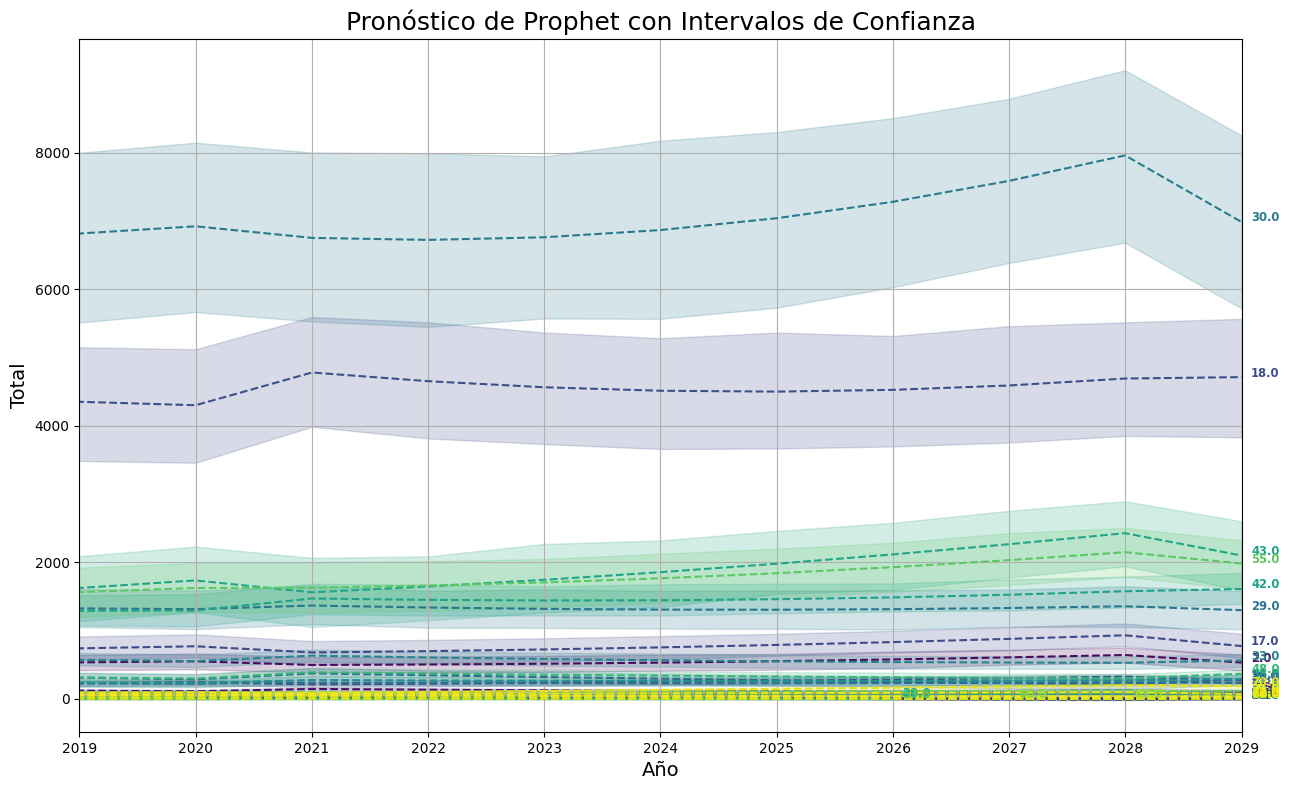

In [37]:
import seaborn as sns

plt.figure(figsize=(15, 9))
ax = plt.gca()

lista_municipios = df_agrupado['municipio'].unique()
palette = sns.color_palette("viridis", n_colors=len(lista_municipios))

for i, municipio_id in enumerate(lista_municipios):
    
    color = palette[i]
    
    hist_data = df_agrupado[df_agrupado['municipio'] == municipio_id]
    forecast_data = df_final_prophet[df_final_prophet['municipio'] == municipio_id]
    
    ax.scatter(hist_data['año_defuncion'], hist_data['total'], color=color, label=f'Datos Históricos Mun. {municipio_id}', s=50)
    
    ax.plot(forecast_data['ds'], forecast_data['yhat'], color=color, linestyle='--', label=f'Predicción Mun. {municipio_id}')
    
    ax.fill_between(
        forecast_data['ds'],
        forecast_data['yhat_lower'],
        forecast_data['yhat_upper'],
        color=color,
        alpha=0.2  
    )

    forecast_data = forecast_data.sort_values(by='ds')

    if not forecast_data.empty: 
        ultimo_punto_forecast = forecast_data.iloc[-1]
        x_pos = ultimo_punto_forecast['ds']
        y_pos = ultimo_punto_forecast['yhat']

        x_offset = pd.to_timedelta('30 days')
        y_offset = 10
        
        ax.text(x_pos + x_offset, y_pos + y_offset, str(municipio_id), 
                 horizontalalignment='left', size='small', color=color, weight='semibold')

ultimo_año_historico = df_agrupado['año_defuncion'].max()
ultimo_año_prediccion = df_final_prophet['ds'].max().year

año_inicio_rango = int(ultimo_año_historico) - 5
año_fin_rango = int(ultimo_año_prediccion) + 1

ax.set_xlim(pd.to_datetime(f'{año_inicio_rango}-01-01'), pd.to_datetime(f'{año_fin_rango}-01-01'))

ax.set_title('Pronóstico de Prophet con Intervalos de Confianza', fontsize=18)
ax.set_xlabel('Año', fontsize=14)
ax.set_ylabel('Total', fontsize=14)
plt.grid(True)
plt.savefig("prediccion_prophet_defunciones.png") # Es buena práctica incluir la extensión
plt.show()

In [ ]:
from sklearn.linear_model import LinearRegression

modelo = LinearRegression()

In [41]:
import numpy as np

lista_municipios = df_agrupado['municipio'].unique()

resultados_predicciones = []
años_futuros = np.array([2025, 2026, 2027, 2028, 2029]).reshape(-1, 1)

In [43]:
for municipio_id in lista_municipios:
    print(f"Procesando Municipio {municipio_id}...")
    
    df_municipio = df_agrupado[df_agrupado['municipio'] == municipio_id]
    
    if len(df_municipio) > 1:
        X = df_municipio['año_defuncion'].values.reshape(-1, 1)
        y = df_municipio['total'].values
        
        modelo = LinearRegression()
        modelo.fit(X, y)
        
        prediccion_futura = modelo.predict(años_futuros)
        
        for i, año in enumerate(años_futuros.flatten()):
            resultados_predicciones.append({
                'municipio': municipio_id,
                'año_prediccion': año,
                'total_predicho': prediccion_futura[i]
            })

Procesando Municipio 1.0...
Procesando Municipio 2.0...
Procesando Municipio 3.0...
Procesando Municipio 4.0...
Procesando Municipio 5.0...
Procesando Municipio 6.0...
Procesando Municipio 8.0...
Procesando Municipio 9.0...
Procesando Municipio 10.0...
Procesando Municipio 11.0...
Procesando Municipio 12.0...
Procesando Municipio 13.0...
Procesando Municipio 14.0...
Procesando Municipio 15.0...
Procesando Municipio 16.0...
Procesando Municipio 17.0...
Procesando Municipio 18.0...
Procesando Municipio 19.0...
Procesando Municipio 20.0...
Procesando Municipio 21.0...
Procesando Municipio 22.0...
Procesando Municipio 23.0...
Procesando Municipio 24.0...
Procesando Municipio 25.0...
Procesando Municipio 26.0...
Procesando Municipio 27.0...
Procesando Municipio 28.0...
Procesando Municipio 29.0...
Procesando Municipio 30.0...
Procesando Municipio 31.0...
Procesando Municipio 32.0...
Procesando Municipio 33.0...
Procesando Municipio 34.0...
Procesando Municipio 35.0...
Procesando Municipio 3

In [44]:
df_resultados = pd.DataFrame(resultados_predicciones)

print("\n--- PREDICCIONES FINALES ---")
print(df_resultados)


--- PREDICCIONES FINALES ---
     municipio  año_prediccion  total_predicho
0          1.0            2025       12.000000
1          1.0            2026       11.428571
2          1.0            2027       10.857143
3          1.0            2028       10.285714
4          1.0            2029        9.714286
..         ...             ...             ...
345       72.0            2025       40.428571
346       72.0            2026       37.821429
347       72.0            2027       35.214286
348       72.0            2028       32.607143
349       72.0            2029       30.000000

[350 rows x 3 columns]


In [45]:
df_historico_plot = df_agrupado.copy()
df_historico_plot['tipo'] = 'Histórico'

df_prediccion_plot = df_resultados.copy()
df_prediccion_plot.rename(columns={
    'año_prediccion': 'año_defuncion',
    'total_predicho': 'total'
}, inplace=True)
df_prediccion_plot['tipo'] = 'Predicción'

df_completo = pd.concat([df_historico_plot, df_prediccion_plot])

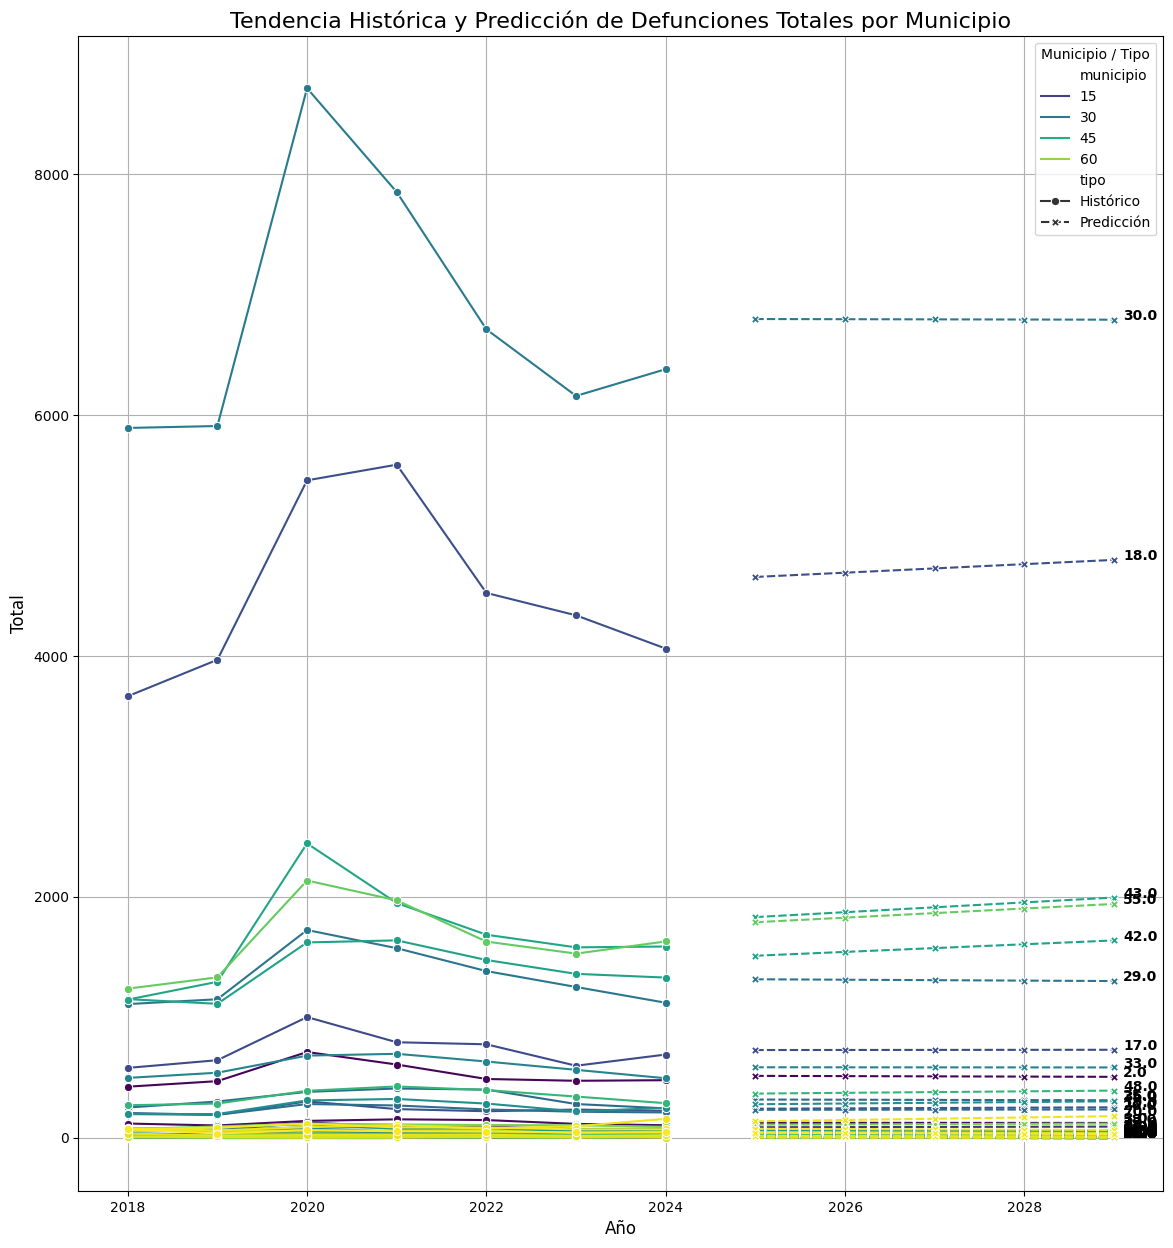

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 15))

sns.lineplot(
    data=df_completo,
    x='año_defuncion',
    y='total',
    hue='municipio',
    style='tipo',
    markers=True,
    palette='viridis'
)

for municipio_id in df_completo['municipio'].unique():
    df_municipio = df_completo[df_completo['municipio'] == municipio_id]
    
    df_municipio = df_municipio.sort_values(by='año_defuncion')
    
    ultimo_punto = df_municipio.iloc[-1]
    x_pos = ultimo_punto['año_defuncion']
    y_pos = ultimo_punto['total']
    
    plt.text(x_pos + 0.1, y_pos, str(municipio_id), 
             horizontalalignment='left', size='medium', color='black', weight='semibold')

plt.title('Tendencia Histórica y Predicción de Defunciones Totales por Municipio', fontsize=16)
plt.xlabel('Año', fontsize=12)
plt.ylabel('Total', fontsize=12)
plt.legend(title='Municipio / Tipo') 
plt.grid(True)
plt.savefig("prediccion_defuncion")
plt.show()